# Задача 7. Нейронные сети


1. Найти данные в виде изображений для задачи классификации
2. Реализовать классы, необходимые для построения сети со следующими слоями
   FullyConnectedLayer
   ReluLayer
   FullyConnectedLayer
3. Использовать CrossEntropyLoss и L2-регуляризацию.
4. Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
5. (+2 балла) Добавить Batch normalization.
6. (+2 балла) В качестве оптимизатор использовать один из: Momentum, RMSprop.
7. (+1 балл) Также реализовать оптимизатор Adam.


## Датасет


Для решения задачи классификации с помощью нейронной сети возьмем предложенный в задании датасет [Street View House Numbers (SVHN)](https://www.kaggle.com/datasets/stanfordu/street-view-house-numbers)


In [27]:
!pip install torch
!pip install torchvision
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 10.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from itertools import product
import pandas as pd

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # → [-1, 1]
])

In [11]:
train_dataset = SVHN(
    root="/Users/kseniia/Desktop/dataset", 
    split='train', 
    download=True, 
    transform=transform)

test_dataset = SVHN(
    root="/Users/kseniia/Desktop/dataset", 
    split='test', 
    download=True, 
    transform=transform)

In [12]:
len(train_dataset), len(test_dataset)

(73257, 26032)

In [13]:
val_size = int(0.3 * len(train_dataset))
train_size = len(train_dataset) - val_size

val_size, train_size

(21977, 51280)

In [14]:
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
def imshow(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    np_img = img_tensor.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))  # (C, H, W) → (H, W, C)
    np_img = np.clip(np_img, 0, 1)
    plt.imshow(np_img)
    plt.axis('off')

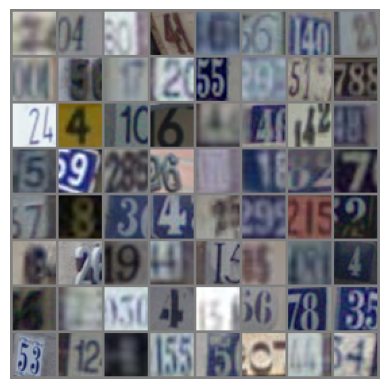

In [16]:
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)  # (B, C, H, W)
imshow(grid)
plt.show()

## Построение сети


In [18]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(in_features, out_features) * 
            torch.sqrt(torch.tensor(2.0 / in_features))
        )
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias 
    
    def backward(self, grad_output):
        grad_input = grad_output @ self.weights.t()
        self.weights.grad = self.x.t() @ grad_output
        self.bias.grad = grad_output.sum(dim=0)
        return grad_input


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return F.relu(x)
    
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.x <= 0] = 0
        return grad_input

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(3*32*32, hidden_size)
        self.relu1 = ReluLayer() 
        self.bn1 = nn.BatchNorm1d(hidden_size) if batch_normalization else None
        self.fc2 = FullyConnectedLayer(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.relu1(x)
        if self.batch_normalization:
            x = self.bn1(x)
        x = self.fc2(x)
        return x

## Оптимизатор Adam


In [20]:
import torch
from torch import optim

class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.states = []
        for p in self.params:
            if p.requires_grad:
                state = {
                    'm': torch.zeros_like(p.data),
                    'v': torch.zeros_like(p.data),
                    't': 0
                }
                self.states.append(state)
            else:
                self.states.append(None)
        
        self.t = 0 

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for i, (param, state) in enumerate(zip(self.params, self.states)):
            if param.grad is None or state is None:
                continue
                
            grad = param.grad.data
            
            # L2 регуляризация (AdamW-style)
            if self.weight_decay != 0:
                grad = grad.add(param.data, alpha=self.weight_decay)
            
            state['m'] = state['m'].mul(beta1).add(grad, alpha=1 - beta1)
            state['v'] = state['v'].mul(beta2).addcmul(grad, grad, value=1 - beta2)
            
            m_hat = state['m'] / (1 - beta1 ** self.t)
            v_hat = state['v'] / (1 - beta2 ** self.t)
            
            param.data.addcdiv_(m_hat, v_hat.sqrt().add(self.eps), value=-self.lr)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

def get_optimizer(name, params, lr, **kwargs):
    optimizers = {
        'adam': lambda: AdamOptimizer(params, lr=lr, **kwargs),
        'momentum': lambda: optim.SGD(params, lr=lr, momentum=0.9, **kwargs),
        'sgd': lambda: optim.SGD(params, lr=lr, **kwargs)
    }
    
    if name not in optimizers:
        raise ValueError(f"Unknown optimizer: {name}. Available: {list(optimizers.keys())}")
    
    return optimizers[name]()

In [21]:
def check_gradient(model, inputs, targets, criterion, delta=1e-3):
    model.eval()
    model.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()

    param_list = [param for param in model.parameters() if param.requires_grad]
    total_params = sum(p.numel() for p in param_list)
    num_checks = 15

    if num_checks > total_params:
        num_checks = total_params

    selected_indices = torch.randperm(total_params)[:num_checks]

    for param in param_list:
        param_data_flat = param.data.view(-1)
        param_grad_flat = param.grad.view(-1)

        for idx in selected_indices:
            if idx >= param_data_flat.size(0):
                break

            original_value = param_data_flat[idx].item()

            param_data_flat[idx] = original_value + delta
            loss_plus = criterion(model(inputs), targets).item()

            param_data_flat[idx] = original_value - delta
            loss_minus = criterion(model(inputs), targets).item()

            param_data_flat[idx] = original_value

            estimated_grad = (loss_plus - loss_minus) / (2 * delta)
            actual_grad = param_grad_flat[idx].item()

            if abs(estimated_grad - actual_grad) > delta:
                print(f'Gradient check failed')
                return False

    print('Gradients check passed')
    return True

## Обучение


In [22]:
def train(model, trainloader, valloader, criterion, optimizer, epochs=10):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        

        train_loss.append(running_loss/len(trainloader))
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/len(valloader))
        
        check_gradient(model, *next(iter(trainloader)), criterion)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")
    
    return train_loss, val_loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import DataLoader

def run_experiments(models, lrs, optimizers, train_loader, val_loader, num_epochs=10):
    results = []
    
    for model_config, lr, optim_name in product(models, lrs, optimizers):
        model = NeuralNetwork(batch_normalization=model_config['batch_norm'])
        model = model.to(device)
        
        if model_config.get('seed'):
            torch.manual_seed(model_config['seed'])
            model.apply(init_weights)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = get_optimizer(optim_name, model.parameters(), lr)
        
        print(f"\nTraining {model.__class__.__name__} "
              f"with lr={lr}, optimizer={optim_name}, "
              f"batch norm={model_config['batch_norm']}")
        
        try:
            train_loss, val_loss = train(
                model=model,
                trainloader=train_loader,
                valloader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=num_epochs
            )
            
            results.append({
                'model_type': 'BN' if model_config['batch_norm'] else 'NoBN',
                'lr': lr,
                'optimizer': optim_name,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'final_train_loss': train_loss[-1],
                'final_val_loss': val_loss[-1]
            })
            
            plot_losses(train_loss, val_loss, model_config, lr, optim_name)
            
        except Exception as e:
            print(f"Experiment failed: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

def plot_losses(train_loss, val_loss, model_config, lr, optim_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Val Loss', marker='s')
    plt.title(f"BN={model_config['batch_norm']}, lr={lr}, Optim={optim_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"loss_BN_{model_config['batch_norm']}_lr_{lr}_{optim_name}.png")
    plt.close()

experiment_config = {
    'models': [{'batch_norm': False, 'seed': 42}, 
               {'batch_norm': True, 'seed': 42}],
    'lrs': [0.001, 0.01],
    'optimizers': ['adam', 'momentum'],
    'num_epochs': 10
}

results_df = run_experiments(
    models=experiment_config['models'],
    lrs=experiment_config['lrs'],
    optimizers=experiment_config['optimizers'],
    train_loader=trainloader,
    val_loader=valloader,
    num_epochs=experiment_config['num_epochs']
)

print("\nBest configurations:")
print(results_df.sort_values('final_val_loss').head())

results_df.to_csv('experiment_results.csv', index=False)


Training NeuralNetwork with lr=0.001, optimizer=adam, batch norm=False
Gradients check passed
Epoch 1/10, Train Loss: 1.4126789968953168, Val Loss: 1.0201207666203034
Gradients check passed
Epoch 2/10, Train Loss: 0.9517976993188596, Val Loss: 0.8739047036614529
Gradients check passed
Epoch 3/10, Train Loss: 0.815917406519155, Val Loss: 0.8327326741675998
Gradients check passed
Epoch 4/10, Train Loss: 0.7421290247034551, Val Loss: 0.8102492864222027
Gradients check passed
Epoch 5/10, Train Loss: 0.6879016787482616, Val Loss: 0.7816299287558988
Gradients check passed
Epoch 6/10, Train Loss: 0.6586628695229937, Val Loss: 0.7368125864412896
Gradients check passed
Epoch 7/10, Train Loss: 0.6147929689384756, Val Loss: 0.7409182166637376
Gradients check passed
Epoch 8/10, Train Loss: 0.6082109748536809, Val Loss: 0.6994431309921797
Gradients check passed
Epoch 9/10, Train Loss: 0.5779055243827161, Val Loss: 0.7080648487303839
Gradients check passed
Epoch 10/10, Train Loss: 0.564922114169954

## Результаты


In [3]:
results = pd.read_csv('/Users/kseniia/ml-course/homework/hw7/results/experiment_results.csv')  
results

,model_type,lr,optimizer,train_loss,val_loss,final_train_loss,final_val_loss
0,NoBN,0.001,adam,"[1.4126789968953168, 0.9517976993188596, 0.815...","[1.0201207666203034, 0.8739047036614529, 0.832...",0.564922,0.698128
1,NoBN,0.001,momentum,"[1.9109197461099696, 1.3864884609890697, 1.167...","[1.5715905369021173, 1.2606049081267312, 1.116...",0.768972,0.806672
2,NoBN,0.010,adam,"[2.250666468592356, 1.4317945719805738, 1.5305...","[1.3764076600241106, 1.4218153717905977, 1.621...",1.609600,1.940356
3,NoBN,0.010,momentum,"[1.3277895604434453, 0.9150182234304505, 0.786...","[1.0223318201511404, 0.8639997259475464, 0.822...",0.552868,0.670927
4,BN,0.001,adam,"[1.4663131781052472, 1.0356348726963462, 0.904...","[1.1158808159620264, 0.9601248450750528, 0.912...",0.657126,0.713104
5,BN,0.001,momentum,"[1.610108307026271, 1.1042687681101802, 0.9686...","[1.1910585048933362, 1.0269025416914808, 0.949...",0.666701,0.715467
6,BN,0.010,adam,"[1.5503993479539628, 1.101531020052118, 0.9820...","[1.1242614558269812, 0.9984958627542784, 0.954...",0.731928,0.734612
7,BN,0.010,momentum,"[1.4524646466806939, 1.0468389975311156, 0.919...","[1.09313568784747, 0.9627983157717904, 0.91986...",0.655832,0.727761


Лучший результат (train: 0.552868, val: 0.670927) посчитала модель без Batch Normalization, с learning rate = 0.01 и с оптимизатором Momentum. Также неплохой результат (train: 0.564922, val: 0.698128) посчитала модель  без Batch Normalization со значение learning rate = 0.001 и с оптимизатором Adam.

![img1](results/loss_BN_False_lr_0.01_momentum.png)

![img1](results/loss_BN_False_lr_0.001_adam.png)

![img1](results/loss_BN_False_lr_0.001_momentum.png)